# Thông tin sinh viên:
**Họ và tên** :  Đặng Thế Hoàng Anh <br>
**Mã số sinh viên** : 19021215

# 1. Giới thiệu về bài toán
Home Depot là một trang web bán hàng gia dụng và có thể cung cấp cho người dùng đủ mọi thứ để có thể cải thiện ngôi nhà của mình. Bằng việc sử dụng trang web này khách hàng có thể có được mọi thứ thông qua việc mua bán online từ đó có thể nhận được những món đồ mà mình ưng ý một cách nhanh chóng nhất. Nhưng vấn đề đặt ra cho thương mại điện tử đó là phải cung cấp cho người dùng một trải nghiệm tốt nhất khi mua hàng, từ tốc độ đến việc gợi ý mua hàng cần nhanh chóng và chuẩn xác. Chính vì vậy Home Depot đã đưa ra một hệ thống giúp gợi ý cho người dùng các sản phẩm có liên quan đến nhau thông bằng việc dự đoán chúng. Hiện tại thì Home Depot mới chỉ sử dụng một hệ thống đánh giá bằng con người và để hạn chế việc này cũng như mở rộng hơn việc gợi ý thì bài toán đặt ra cho chúng ta là từ các dữ liệu đó sử dụng các thuật toán tìm kiếm hợp lý cùng các kỹ thuật khác liên quan đến học máy, xử lý ngôn ngữ tự nhiên.

Như vậy đầu vào của chúng ta sẽ là một loạt các sản phẩm cùng các cụm từ được tìm kiếm từ trang Home Depot. Các cặp từ tìm kiếm và sản phẩm này được cung cấp bởi nhiều người trong cộng đồng với mục tiêu là dự đoán mức độ phù hợp của các cặp này. Để đảm bảo độ chính xác thì chúng được đánh giá thông qua ít nhất là 3 người sau đó lấy giá trị trung bình, các mức độ này được chia làm 3 loại không liên quan tương ứng với 1 điểm, liên quan nhẹ tương ứng với 2 điểm và rất liên quan là 3 điểm.

Đầu ra cần có đó là dựa vào các dữ liệu trên thì đưa ra được dự đoán mức độ liên quan giữa cặp từ tìm kiếm và sản phẩm trong tập dữ liệu kiểm thử sao cho hợp lý nhất.

# 2. Tìm hiểu phân tích và xử lý dữ liệu

## 2.1 Các bước chuẩn bị
### 2.1.1 Các thư viện sử dụng trong bài toán

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore some annoying warning
import numpy as np # linear algebra
import pandas as pd # data processing
import os # Any results you write to the current directory are saved as output.
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization plot 
import re #regex for cleaning
import gensim # remove stop word 
import math # to calculate

### 2.1.2 Giải nén dữ liệu

In [ ]:
!unzip ../input/home-depot-product-search-relevance/product_descriptions.csv.zip
!unzip ../input/home-depot-product-search-relevance/train.csv.zip
!unzip ../input/home-depot-product-search-relevance/test.csv.zip
!unzip ../input/home-depot-product-search-relevance/attributes.csv.zip

## 2.2 Tìm hiểu về dữ liệu
Về tổng quan thì dữ liệu cho ta 4 tập CSV đó là : train.csv, product_descriptions.csv, attributes.csv và test.csv.
### 2.2.1 Load dữ liệu thành các dataframe

In [ ]:
train_df = pd.read_csv('train.csv', encoding="ISO-8859-1");
product_descriptions_df = pd.read_csv('product_descriptions.csv');
attributes_df = pd.read_csv('attributes.csv');
test_df = pd.read_csv('test.csv', encoding="ISO-8859-1");

### 2.2.2 Tìm hiểu từng tệp dữ liệu
#### 2.2.2.1 Tệp dữ liệu huấn luyện và tập kiểm thử

In [ ]:
print(train_df.shape)
train_df.head(5)

Có thể thấy rằng tập dữ liệu huấn luyện này bao gồm 74067 dòng, mỗi dòng ở trên tương ứng với từng cặp dữ liệu được cho, trên đó bao gồm các thông tin về mã sản phẩm, tên của sản phẩm đó cùng với cụm từ tìm kiếm tương ứng và điểm số cho mức độ liên quan của cặp sản phẩm và cụm từ tìm kiếm này. product_uid là trường dữ liệu để định danh cho sản phẩm và mỗi sản phẩm chỉ có 1 uid. Như trong dữ liệu trên có thể thấy một sản phẩm được lặp lại ở nhiều dòng tương ứng với việc mỗi sản phẩm có thể có các mức độ liên quan khác nhau đến nhiều cụm từ được tìm kiếm.

In [ ]:
print(test_df.shape)

Tệp test thì tương tự với tệp train nhưng có nhiều dữ liệu hơn với 166693 bản ghi.

#### 2.2.2.2 Tệp product description

In [ ]:
print(product_descriptions_df.shape)
product_descriptions_df.head(5)

Tương tự như ở trên thì product_descriptions.csv bao gồm 124428 dòng tương ứng với 124428 sản phẩm cùng với 1 phần mô tả chi tiết về sản phẩm đó.

#### 2.2.2.3 Tệp attributes

In [ ]:
print(attributes_df.shape)
attributes_df.head(5)

Tệp này bao gồm 3 loại thuộc tính ngoài uid thì còn có tên của thuộc tính và giái trị ở đây là giá trị của các thuộc tính đó, một sản phẩm bao gồm nhiều thuộc tính khác nhau.

## 2.3 Phân tích dữ liệu

Bây giờ ta sẽ đi vào phân tích các dữ liệu đã có thông qua việc phân tích các thuộc tính trước và sau đó tìm ra được các thuộc tính có giá trị rồi ghép các bảng lại với nhau để thực hiện Feature engineering.

### 2.3.1 Product_uid
Ta sẽ đi xem xét product_uid trong từng bảng một và xét xem chúng trùng lặp như thế nào

In [ ]:
# number of product uid in 4 tables
unique_uid_train_df = train_df['product_uid'].unique()
print(f'There are {unique_uid_train_df.size} products in train.csv')
unique_uid_product_descriptions_df = product_descriptions_df['product_uid'].unique()
print(f'There are {unique_uid_product_descriptions_df.size} products in product_descriptions.csv')
unique_uid_attributes_df = attributes_df['product_uid'].unique()
print(f'There are {unique_uid_attributes_df.size} products in attributes.csv')
unique_uid_test_df = test_df['product_uid'].unique()
print(f'There are {unique_uid_test_df.size} products in test.csv')
# plot for this data
x = ['Train', 'product_descriptions', 'attributes', 'test']
y = [unique_uid_train_df.size, unique_uid_product_descriptions_df.size, unique_uid_attributes_df.size,unique_uid_test_df.size] 
sns.barplot(x, y)
plt.title('number of product uid in 4 tables')
plt.show()

Như biểu đồ trên thì có thể thấy rằng nếu như sử dụng các attribute cho test thì khi ghép vào chắc chắn là sẽ không đủ được số lượng attribute còn product_descriptions sẽ đủ cho cả test và train. Nhưng nếu nhìn như trên thì chỉ thấy được số lượng chứ chưa thấy được thật sự là chúng có trùng khớp với nhau hay không nên ta sẽ đi xét 1 số venn diagram để nhìn được chi tiết hơn phần trùng lặp.

In [ ]:
# import venn diagram 
from matplotlib_venn import venn2 
train_and_attributes = len([i for i in unique_uid_attributes_df if i in unique_uid_train_df ])
attributes_only = unique_uid_attributes_df.size - train_and_attributes
train_only = unique_uid_train_df.size - train_and_attributes
# depict venn diagram for train and attributes set
venn2(subsets=(train_only, attributes_only, train_and_attributes), 
      set_labels=('Train', 'Attributes'))
plt.title('venn diagram for train and attributes set')
plt.show()
train_and_product_descriptions = len([i for i in unique_uid_product_descriptions_df if i in unique_uid_train_df ])
product_descriptions_only = unique_uid_product_descriptions_df.size - train_and_product_descriptions
train_only = unique_uid_train_df.size - train_and_product_descriptions
# depict venn diagram for train and product descriptions set
venn2(subsets=(train_only, product_descriptions_only, train_and_product_descriptions), 
      set_labels=('Train', 'Product_descriptions'))
plt.title('venn diagram for train and product descriptions set')
plt.show()

Như vậy có thể thấy rằng tập train và tập attributes vẫn còn tới 16263 sản phẩm chưa có attribute nên khi ghép chúng lại ta cần lưu ý một số thứ còn với tập product_descriptions thì không có sản phẩm nào không có miêu tả cả nên có thể gộp thoải mái.

### 2.3.2 Các trường trong attributes
Khi xét đến các tên của attribute ta có

In [ ]:
attributes_df['name'].value_counts().head(15)

Ta thấy rằng các trường nhiều nhất thì chỉ có Brand là có ý nghĩa còn lại nhưng trường như bullet01 02 03 04 thì không có nhiều ý nghĩa cho lắm còn các trường có giá trị khác thì lại ít hơn nhiều nên ta sẽ lấy brand làm một trường riêng làm đại diện và các phần còn lại của attributes gộp vào thành 1 trường thống nhất để ghép vào với các bảng khác dễ dàng hơn.

### 2.3.3 Điểm relevance


In [ ]:
sns.countplot(train_df.relevance)

Nhìn qua thì ta thấy được rằng điểm chủ yếu phân bố ở phía trên 2 điểm, bởi vì phần điểm này là do người đánh giá và thường nhắm vào việc đánh giá những cặp sản phẩm và search có liên quan nhất nên phân phối khá lệch và không giống phân phối chuẩn tự nhiên. Các điểm 1.25, 1.5, 1.75, 2.25, 2.5 và 2.75 là rất thấp hoặc hầu như không có bởi vì hầu hết được đánh giá bởi 3 người và khi chia ra sẽ không thể ra được các con số trên nên khi tiếp tục thực hiện bài toán ta có thể bỏ qua các đầu điểm này để dễ dàng phân tích hơn.

### 2.3.4 Ghép các bảng lại với nhau 
Sau khi phân tích các bảng riêng lẻ thì ta tiến hành ghép chúng lại với nhau trước khi triển khai xử lý dữ liệu. Ta sẽ ghép tập train với 2 tập còn lại thông qua product uid và cùng với đó như đã nói ở phần trên thì ta sẽ đưa ra attributes có giá trị nhất là brand làm 1 thuộc tính riêng.

In [ ]:
# separate brands from attributes
brands = attributes_df[attributes_df['name'] == "MFG Brand Name"]
brands_df = brands[['product_uid','value']].rename(columns = {'value':'brand'})
brands_df.head(10)

In [ ]:
# merge brand and product descriptions with train
merged_df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
merged_df = pd.merge(merged_df, brands_df, on='product_uid', how='left')
merged_df = pd.merge(merged_df, product_descriptions_df, on='product_uid', how='left')
merged_df

## 2.4 Xử lý và làm sạch dữ liệu

### 2.4.1 Xử lí missing data sau khí ghép các bảng lại với nhau
Bởi vì có sự chênh lệch product uid giữa các bảng nên khi ghép chúng lại với nhau sẽ ra các trường giá trị NaN đồng thời ở giữa chúng cũng có các giá trị null cần được xử lý trước khi đi vào xử lý các bước tiếp theo. Xem xét các trường ta có được: 

In [ ]:
sns.heatmap(merged_df.isnull(), cbar=False)

Có thể dễ dàng đoán được kết quả trên đó là chỉ có brands là có các giá trị null bời brands chỉ có 1 phần products có trong train. Chính vì vậy việc của ta là lấp đầy chúng bằng 1 cách nào đó.

In [ ]:
merged_df[['product_uid','product_title','brand']].head(10)

Nhìn ở trên thì cũng có thế nhận ra được rằng các brand thường sẽ là các chữ cái đầu của trường product_title nên ta có thể tận dùng điều này bằng các so sánh các product title với các brand hiện có để tìm ra được brand của sản phẩm đó, nếu sau khi xử lý xong mà vẫn còn lại các phần bị null thì ta sẽ lấy bằng các từ đầu của product_titlte.

In [ ]:
# get specific brands
specific_brands = merged_df['brand'].dropna().unique()
num_words = [len(sentence.split()) for sentence in specific_brands]
print(f'The max number of words in brands is {max(num_words)}')
number_of_null = merged_df['brand'].isna().values.sum()
print(f'Number of null brand: {number_of_null}')

Bởi vì brand dài nhất có tới 6 từ nên ta sẽ xét từ 1 đến 6 từ của product title để thêm vào brand.

In [ ]:
number_of_null = merged_df['brand'].isna().values.sum()
print(f'Number of null brand: {number_of_null}')

Như vậy là ta đã thêm đầy đủ toàn bộ giá trị null của trường brand.

### 2.4.2 Định dạng lại dữ liệu
Tiếp theo chúng ta sẽ định dạng lại dữ liệu bằng cách chuẩn hóa chúng sử dụng regex.

In [ ]:
def clean_data(data): 
    data = data.lower() # lowercase 
    data = data.replace('in.', ' inch ') # to distinguish in and inch
    cleaned_data = re.sub('\W+',' ', data) # clean all special character and split words
    cleaned_data = re.sub(r"([0-9])([a-z])", r"\1 \2", cleaned_data) # split number and word
    cleaned_data = re.sub(r"([a-z])([0-9])", r"\1 \2", cleaned_data)
    cleaned_data = re.sub('( gal | gals | galon )',' gallon ',cleaned_data) # convert units of measurements
    cleaned_data = re.sub('( ft | fts | feets | foot | foots )',' feet ',cleaned_data)
    cleaned_data = re.sub('( squares | sq )',' square ',cleaned_data)
    cleaned_data = re.sub('( lb | lbs | pounds )',' pound ',cleaned_data)
    cleaned_data = re.sub('( oz | ozs | ounces | ounc )',' ounce ',cleaned_data)
    cleaned_data = re.sub('( yds | yd | yards )',' yard ',cleaned_data)
    cleaned_data = re.sub('( centimeters | cm )',' cm ',cleaned_data)
    cleaned_data = re.sub('( milimeters | mm )',' mm ',cleaned_data)
    cleaned_data = re.sub('( ° | degrees | degree )',' deg ',cleaned_data)
    cleaned_data = re.sub('( v | volts | volt )',' volt ',cleaned_data)
    return cleaned_data


In [ ]:
print(clean_data('asdas232DASDSA1dasd]]545835+* gals,  ozs  *awdad'))

In [ ]:
merged_df['product_title'] = merged_df['product_title'].map(lambda x:clean_data(x))
merged_df['brand'] = merged_df['brand'].map(lambda x:clean_data(x))
merged_df['search_term'] = merged_df['search_term'].map(lambda x:clean_data(x))
merged_df['product_description'] = merged_df['product_description'].map(lambda x:clean_data(x))

Sau khi clean xong thì ta thu được dữ liêu như sau:

In [ ]:
merged_df

Bởi vì search term là do người dùng nhập vào nên sẽ có những lỗi chính tả vì vậy ta cần phải sửa lại chúng sao cho hợp lý. Ở đây ta sử dụng phần Spelling Corrector của Peter Norvig's implementation. [Link Here](https://norvig.com/spell-correct.html)


In [ ]:
# Code from Perter Norvig to spell check
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../input/bigtxt1/big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [ ]:
# function to correct all words in a sentence
def correct_words(data):
    word_list = data.split()
    corrected_words = [correction(word) for word in word_list]
    corrected_data = ' '.join(corrected_words)
    return corrected_data

In [ ]:
merged_df['search_term'] = merged_df['search_term'].map(lambda x: correct_words(x))

In [ ]:
merged_df

Sau khi spell check xong thì đến các công việc còn lại là xử lý stop word và stemming. Stemming là kỹ thuật dùng để biến đổi 1 từ về dạng gốc bằng cách loại bỏ đi các ký tự thể hiện từ loại của từ, do đó có thể so sánh các từ dễ dàng hơn.

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()
# function to stem and remove stop word
def stem_word(data):
    data = remove_stopwords(data)
    word_list = data.split()
    stemmed_words = [ps.stem(word) for word in word_list]
    return ' '.join(stemmed_words)

In [ ]:
final_df = pd.DataFrame() 
final_df['id'] = merged_df['id']
final_df['product_title'] = merged_df['product_title'].map(lambda x:stem_word(x))
final_df['brand'] = merged_df['brand'].map(lambda x:stem_word(x))
final_df['search_term'] = merged_df['search_term'].map(lambda x:stem_word(x))
final_df['product_description'] = merged_df['product_description'].map(lambda x:stem_word(x))
final_df['product_uid'] = merged_df['product_uid']
final_df['relevance'] = merged_df['relevance']

In [ ]:
final_df

## 2.5 Trích xuất đặc trưng
Trích chọn thuộc tính là việc tìm ra một tập thuộc tính mới từ tập thuộc tính ban đầu nhằm nâng cao hiệu suất tính toán và độ chính xác phân lớp. Đây là một quá trình quan trọng trước khi đưa dữ liệu vào mô hình học máy để có được hiệu quả cao nhất.
### 2.5.1 Dùng các phương pháp toán học
Đầu tiên ta sẽ tạo ra các thuộc tính mới bằng cách sử dụng các phương pháp toán học nhằm số hóa các dữ liệu thô đã cho bởi mô hình học máy chỉ làm việc với các con số như đếm số lượng các từ trong các trường, đếm số lượng các từ giống nhau giữa search_term và các trường còn lại, tính khoảng cách giữa các từ, tìm xem từ cuối cùng của phần search_term có trùng với các trường thông tin còn lại hay không.

* Trước hết là thêm thuộc tính số lượng từ trong mỗi loại

In [ ]:
final_df['words_search_term'] = final_df['search_term'].map(lambda x:len(str(x).split())).astype(np.int64)
final_df['words_brand'] = final_df['brand'].map(lambda x:len(str(x).split())).astype(np.int64)
final_df['words_product_description'] = final_df['product_description'].map(lambda x:len(str(x).split())).astype(np.int64)
final_df['words_product_title'] = final_df['product_title'].map(lambda x:len(str(x).split())).astype(np.int64)

Tiếp đến là đếm số lượng từ giống nhau giữa search_term và các thuộc tính còn lại

In [ ]:
# function to count common word between 2 string
def count_common_word(source,target):
    count = 0
    word_list = source.split()
    for word in word_list: 
        if target.find(word) >= 0:
            count += 1
    return count

In [ ]:
# common word between search and brand
final_df['search_brand_common'] = final_df.apply(lambda x: count_common_word(x['search_term'],x['brand']),axis=1)
# common word between search and description
final_df['search_des_common'] = final_df.apply(lambda x: count_common_word(x['search_term'],x['product_description']),axis=1)
# common word between search and title
final_df['search_title_common'] = final_df.apply(lambda x: count_common_word(x['search_term'],x['product_title']),axis=1)

* Tìm khoảng cách giữa search_term và các trường còn lại. Ở đây ta sẽ áp dụng khoảng cách Jaccard để tính mức độ tương đồng giữa search_term và các phần còn lại của sản phẩm.

![markdown](https://neo4j.com/docs/graph-data-science/current/_images/jaccard.png)

In [ ]:
def jaccard_similarity(str1, str2):
    words_in_str1 = set(str1.split())
    words_in_str2 = set(str2.split())
    # calucate jaccard similarity
    jaccard = float(len(words_in_str1.intersection(words_in_str2))) / len(words_in_str1.union(words_in_str2))
    return jaccard

In [ ]:
# jaccard similarity between search and brand
final_df['search_brand_jaccard'] = final_df.apply(lambda x: jaccard_similarity(x['search_term'],x['brand']),axis=1)
# jaccard similarity between search and description
final_df['search_des_jaccard'] = final_df.apply(lambda x: jaccard_similarity(x['search_term'],x['product_description']),axis=1)
# jaccard similarity between search and title
final_df['search_title_jaccard'] = final_df.apply(lambda x: jaccard_similarity(x['search_term'],x['product_title']),axis=1)

Bên cạnh jaccard similarity ta cũng có thể sử dụng cosine similarity để tính toán độ tương đồng:

![markdown](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

In [ ]:
from collections import Counter
# function to calculate cosine_similarity
def cosine_similarity(str1,str2):
    vec1 = Counter(str1.split())
    vec2 = Counter(str2.split())
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [ ]:
# cosine similarity between search and brand
final_df['search_brand_cosine'] = final_df.apply(lambda x: cosine_similarity(x['search_term'],x['brand']),axis=1)
# cosine similarity between search and description
final_df['search_des_cosine'] = final_df.apply(lambda x: cosine_similarity(x['search_term'],x['product_description']),axis=1)
# cosine similarity between search and title
final_df['search_title_cosine'] = final_df.apply(lambda x: cosine_similarity(x['search_term'],x['product_title']),axis=1)

* tiếp đến là các thuộc tính để kiểm tra xem từ cuối cùng trong search_term có xuất hiện trong các trường của product hay không.

In [ ]:
# function to check last word from source appears in target
def check_last_word(source,target):
    if not source:
        return 0
    word = source.split()[-1]
    if target.find(word) >= 0:
        return 1
    return 0

In [ ]:
# check last word of search in brand
final_df['search_brand_last_word'] = final_df.apply(lambda x: check_last_word(x['search_term'],x['brand']),axis=1)
# check last word of search in description
final_df['search_des_last_word'] = final_df.apply(lambda x: check_last_word(x['search_term'],x['product_description']),axis=1)
# check last word of search in title
final_df['search_title_last_word'] = final_df.apply(lambda x: check_last_word(x['search_term'],x['product_title']),axis=1)

Và đây là kết quả thu được sau khi thêm các thuộc tính mới.

In [ ]:
final_df

### 2.5.2 Sử dụng glove model
Đây là một mô hình embedding giống như word2vec, trong trường hợp này ta sử dụng để tính toán sự giống nhau về mặt ngữ nghĩa giữa search_term và các trường còn lại của sản phẩm.

In [ ]:
from scipy import spatial
import gensim.downloader as api
# download api 
model = api.load("glove-wiki-gigaword-50")
def preprocess(str):
    words = str.split()
    for index,word in enumerate(words): 
        if word not in model:
            words[index] = 'unk'
    return words

def get_vector(str):
    return np.sum(np.array([model[i] for i in preprocess(str)]), axis=0)
# function to calculate semantic similarity
def semantic_similarity(str1,str2):
    return 1 - spatial.distance.cosine(get_vector(str1), get_vector(str2))

In [ ]:
# semantic similarity between search and brand
final_df['search_brand_semantic'] = final_df.apply(lambda x: semantic_similarity(x['search_term'],x['brand']),axis=1)
# semantic similarity between search and description
final_df['search_des_semantic'] = final_df.apply(lambda x: semantic_similarity(x['search_term'],x['product_description']),axis=1)
# semantic similarity between search and title
final_df['search_title_semantic'] = final_df.apply(lambda x: semantic_similarity(x['search_term'],x['product_title']),axis=1)

### 2.5.3 Sử dụng TF-IDF
TF-IDF là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Cơ chế để đánh giá là sử dụng mức độ xuất hiện trong các tài liệu khác nhau của một từ và tần suất xuất hiện của từ đó trong một văn bản. Sau đây chúng ta sẽ đi tính độ tương quan cosine với tf-idf cũng như sử dụng tf-idf kết hợp với TruncatedSVD để giảm số chiều của dữ liệu mà vẫn không làm mất đi ý nghĩa của nó.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
svd = TruncatedSVD(n_components=10, random_state = 2019)
pipe = Pipeline(steps=[('tfidf', tfidf),('svd', svd)])

# function to calcultate cosine similarity and tf-idf
def cosine_sim_tfidf(str1, str2):
    clf = tfidf.fit_transform([str1, str2])
    return ((clf * clf.T).A)[0,1]

# cosine similarity between search and description using tf-idf
final_df['search_des_cosine_tfidf'] = final_df.apply(lambda x: cosine_sim_tfidf(x['search_term'],x['product_description']),axis=1)
# cosine similarity between search and title using tf-idf
final_df['search_title_cosine_tfidf'] = final_df.apply(lambda x: cosine_sim_tfidf(x['search_term'],x['product_title']),axis=1)

In [ ]:
# convert field to vector tf-idf
final_df['search_term'] = pipe.fit_transform(final_df['search_term'])
final_df['product_description'] = pipe.fit_transform(final_df['product_description'])
final_df['product_title'] = pipe.fit_transform(final_df['product_title'])
# drop brand cause low number and not use product_uid 
final_df.drop(["brand",'product_uid'],axis=1,inplace=True)

# 3.Mô hình
## 3.1 Tách dữ liệu


Vì ở trên chúng ta đã gộp dữ liệu lại để xử lý toàn bộ nên tiếp theo ta sẽ phải tách dữ liệu ra thành tập train và tập test đồng thời chia ra thành các tập input cho model của chúng ta.

In [ ]:
num_train=train_df.shape[0]
train_df = final_df.iloc[:num_train]
test_df = final_df.iloc[num_train:]
train = train_df.copy()
test = test_df.copy()
id_test = test['id']
y_train = train['relevance'].values
X_train = train.drop(['id','relevance'],axis=1).values
X_test = test.drop(['id','relevance'],axis=1).values

## 3.2 Hàm đánh giá
Root-mean-square error ( RMSE ) là một biện pháp thường được sử dụng trong những khác biệt giữa các giá trị (mẫu hoặc các giá trị dân) được dự đoán bởi một mô hình hay một ước lượng và các giá trị quan sát được. Nó thực hiện điều này bằng cách đo sự khác biệt giữa các giá trị dự đoán và giá trị thực tế . RMSE càng nhỏ tức là sai số càng bé thì mức độ ước lượng cho thấy độ tin cậy của mô hình có thể đạt cao nhất.
![markdown](https://solieu.vip/wp-content/uploads/2020/07/cong-thuc-rmse.png)

Dưới đây ta sẽ đi tính RSME thông qua MSE

In [ ]:
from sklearn.metrics import make_scorer,mean_squared_error
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.1
    return fmean_squared_error

RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

def caculator_RMSE(X_train, y_train, model):
    return np.sqrt(((y_train - model.predict(X_train)) ** 2).mean())

## 3.3 Mô hình

Để nói về mô hình thì xin phép đưa ra phần bài giảng về Gradient Boosting của thầy.

## Thuật toán Gradient Boosting

## Hướng đạo hàm

Thuật toán Gradient Boosting sử dụng lược đồ Additive Boosting với bước tìm $h_m$ sử dụng đạo hàm của hàm lỗi $\ell(\widehat y, y)$. Gọi $f_i^{(m)} = f_{m-1}(\mathbf x_i)$ là giá trị của mô hình tại bước $m$ trên mẫu $\mathbf x_i$. Khi cập nhật $f_m(\mathbf x) = f_{m-1}(\mathbf x) + \beta h(\mathbf x)$ ta được $f_i^{(m+1)} = f_i^{(m)}+\beta h(\mathbf x_i)$. 

Đối với Gradient Boosting, cập nhật này làm thay đổi hàm lỗi theo hướng đạo hàm. Tức là ta cần chọn $h_m$ sao cho

$$
h_m(\mathrm x_i) \approx r_i^{(m)}=\left.-\frac{\partial \ell(\widehat y, y_i)}{\partial\widehat y}\right|_{\widehat y = f_i^{(m)}}=-\ell'(f_i^{(m)}, y_i), i=1,2,\ldots m
$$

Ta tìm $h_m$ bằng việc giải bài toán Hồi quy với tập mẫu huấn luyện $(\mathbf x_i, r_i^{(m)}), i=1,2,\ldots,m$. Sau đó ta giải bài toán tối ưu sau cho $\beta$

$$
\beta_m = \argmin_\beta \sum_{i=1}^n \ell(f_i^{(m)}+\beta h_m(\mathbf x_i), y_i)
$$

Đây là bài toán tối ưu 1 biến trên hàm lỗi đã biết trước. Ví dụ

- Nếu $\ell(\widehat y, y) = (y-\widehat y)^2$ thì lấy đạo hàm và đặt bằng 0 được
    
    $$
    \sum_{i=1}^n (y- f_i^{(m)}-\beta h_m(\mathbf x_i)) h_m(\mathbf x_i) = 0\Rightarrow \beta_m = \frac{\sum_{i=1}^n (y- f_i^{(m)}) h_m(\mathbf x_i)}{\sum_{i=1}^n h_m(\mathbf x_i)^2} 
    $$
    
- Với các hàm lỗi khác có thể giải bằng phương pháp Newton (hàm lồi nên rất nhanh).

![markdown](https://tricky-tax-444.notion.site/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F0d979dc4-ffd6-42ea-8942-c024480033f2%2FUntitled.png?table=block&id=10d9f630-1f9f-4466-bb34-13226d4fa2bd&spaceId=489a998d-9308-40e6-bfe8-44f23a91cf17&width=2000&userId=&cache=v2)

## Thuật toán

$\mathrm{GradientBoost}(\mathcal F, D)$

- Khởi tạo $f_i^{(1)}=0, \forall i$
- Lặp với $m=1,2,\ldots$
    1. Tính hướng đạo hàm
    
    $$
    r_i^{(m)}=\left.-\frac{\partial \ell(\widehat y, y_i)}{\partial\widehat y}\right|_{\widehat y = f_i^{(m)}}=\ell'(f_i^{(m)}, y_i), i=1,2,\ldots, m
    $$
    
    1. Huấn luyện mô hình hồi quy $h_m\in\mathcal F$ sử dụng bộ dữ liệu
    
    $$
    D = \{(\mathbf x_1, r_1^{(m)}),(\mathbf x_2, r_2^{(m)}),\ldots,(\mathbf x_n, r_n^{(m)})\}
    $$
    
    1. Tìm hệ số $\beta_m$ bằng bài toán tối ưu 1 biến
    
    $$
    \beta_m = \argmin_\beta \sum_{i=1}^n \ell(f_i^{(m)}+\beta h_m(\mathbf x_i), y_i)
    $$
    
    1. Cập nhật
    
    $$
    f_i^{(m+1)} = f_i^{(m)}+\beta_m h_m(\mathbf x_i), i=1,2,\ldots, m
    $$
    
- Kết quả $h(\mathbf x) = \sum_{m}\beta_m h_m(\mathbf x)$.

Trong phần report này chúng ta sẽ sử dụng trực tiếp mô hình Gradient Boosting Regessor từ sklearn. Tiếp đến là sử dụng GridSearchCV để tìm ra được tham số tối ưu nhất cho mô hình của mình

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()

In [ ]:

from sklearn.model_selection import GridSearchCV
param_grid = {  'n_estimators' : np.array([int(e) for e in np.linspace(95, 100, 6)]),
                'max_depth': np.array([int(e) for e in np.linspace(1, 10, 11)])
                 }
clf  = GridSearchCV(estimator = GBR, param_grid = param_grid, n_jobs = -1, cv = 2,verbose = 20, scoring=RMSE)

In [ ]:
clf.fit(X_train, y_train)

Sau khi tìm được tham số tối ưu ta đưa chúng vào mô hình và tiến hành huấn luyện

In [ ]:
new_model = GradientBoostingRegressor(max_depth=6,n_estimators=96)
new_model.fit(X_train, y_train)
print ('RMSE using GBRegression : ' , caculator_RMSE(X_train, y_train, new_model))

Cuối cùng sau khi đã hoàn thành được mô hình ta triển khai dự đoán và đưa ra submission

In [ ]:
y_pred = new_model.predict(X_test) 
for i in range(len(y_pred)):
    if y_pred[i] > 3:
        y_pred[i] = 3
    if y_pred[i] < 0:
        y_pred[i] = 0
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

Dưới đây là điểm số đạt được:

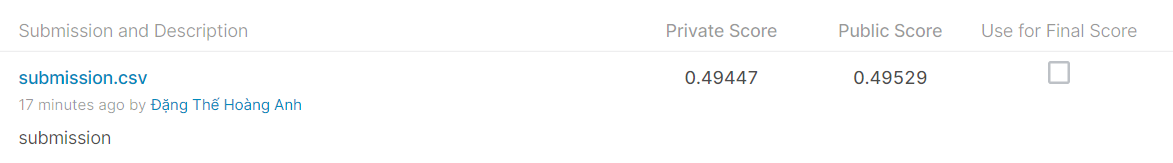

Kết quả đạt được chỉ ở mức rank 1400-1500 mặc dù đã thực hiện cleaning và feature engineering, có lẽ do các hướng tiếp cận là chưa đủ và cũng một phần vì phần xủ lý dữ liệu khá tốn thời gian (mỗi lần chạy mất 1-2 tiếng) hoặc mô hình khá đơn giản nên cần phải cải thiện trong tương lai nếu muốn có được điểm số cao hơn.